# Imports 

In [758]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from scipy.stats import norm


# Data Acquisition, Cleaning, and Wrangling

Data was acquired from Kaggle. Downloaded into a csv file directly from this link: https://www.kaggle.com/vipin20/loan-application-data

In [759]:
df = pd.read_csv('df1_loan.csv', index_col =0)
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,$5849.0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,$6091.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,$3000.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,$4941.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,$6000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,LP002586,Female,Yes,1,Graduate,No,3326,913.0,105.0,84.0,1.0,Semiurban,Y,$4239.0
496,LP002587,Male,Yes,0,Not Graduate,No,2600,1700.0,107.0,360.0,1.0,Rural,Y,$4300.0
497,LP002588,Male,Yes,0,Graduate,No,4625,2857.0,111.0,12.0,NaN,Urban,Y,$7482.0
498,LP002600,Male,Yes,1,Graduate,Yes,2895,0.0,95.0,360.0,1.0,Semiurban,Y,$2895.0


The data was cleaned by dropping all null values and turning all qualitative data into quantitative data. For example, for marital status, *Yes* corresponds to 1, and *No* corresponds to 0

In [760]:
def clean_data(df):
    del df["Loan_ID"]

    df["Total_Income"]=df["Total_Income"].str.replace("$","")
    df["Total_Income"]=df["Total_Income"].apply(pd.to_numeric)

    df["Dependents"]=df["Dependents"].str.replace('+','')
    df["Dependents"]=df["Dependents"].apply(pd.to_numeric)


    df["Self_Employed"] = df["Self_Employed"].astype('category').cat.codes
    df["Gender"] = df["Gender"].astype('category').cat.codes
    df["Married"] = df["Married"].astype('category').cat.codes
    df["Education"] = df["Education"].astype('category').cat.codes
    df["Property_Area"] = df["Property_Area"].astype('category').cat.codes
    df["Loan_Status"] = df["Loan_Status"].astype('category').cat.codes


    df = df.dropna()

    return df

df = clean_data(df)

df.shape

(419, 13)

As a result of dropping null values, we can see the number of samples was reduced from 500 to 419. Additionally the Loan_ID is unnecssary for any model, thus the number of features was reduced to 13. The last data manipulation involved feature extraction. We believed that the size of a family (simply the addition of parents and dependents) and the principal per month (ratio of loan amount to its term) would be important features. 

In [761]:
def fam_size(df):
    fam_size = []
    for m, d in zip(df["Married"], df["Dependents"]):
        fam_size.append(1 + m + d)
    
    df["Family_Size"] = fam_size

    return df


def principal_per_month(df):
    principal_per_month = []
    for la, lat in zip(df["LoanAmount"], df["Loan_Amount_Term"]):
        principal_per_month.append(la / lat)
    
    df["Principal_Per_Month"] = principal_per_month

    return df

df = principal_per_month(fam_size(df))
df

C:\Users\maxnb\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\maxnb\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,Family_Size,Principal_Per_Month
1,1,1,1.0,0,0,4583,1508.0,128.0,360.0,1.0,0,0,6091.0,3.0,0.355556
2,1,1,0.0,0,1,3000,0.0,66.0,360.0,1.0,2,1,3000.0,2.0,0.183333
3,1,1,0.0,1,0,2583,2358.0,120.0,360.0,1.0,2,1,4941.0,2.0,0.333333
4,1,0,0.0,0,0,6000,0.0,141.0,360.0,1.0,2,1,6000.0,1.0,0.391667
5,1,1,2.0,0,1,5417,4196.0,267.0,360.0,1.0,2,1,9613.0,4.0,0.741667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,1,1,0.0,0,0,3597,2157.0,119.0,360.0,0.0,0,0,5754.0,2.0,0.330556
495,0,1,1.0,0,0,3326,913.0,105.0,84.0,1.0,1,1,4239.0,3.0,1.250000
496,1,1,0.0,1,0,2600,1700.0,107.0,360.0,1.0,0,1,4300.0,2.0,0.297222
498,1,1,1.0,0,1,2895,0.0,95.0,360.0,1.0,1,1,2895.0,3.0,0.263889


Above can be seen the two extra features in the DataFrame. Next, we will separate the features from the target

In [762]:
def get_features_target():

    target_column = f"Loan_Status"
    target = df[target_column].dropna()

    df2 = df.copy()
    del df2[target_column]

        
    scaler = StandardScaler()
    scaler.fit(df2)
    df2 = scaler.transform(df2)

    return df2, target

features, target = get_features_target()



Then we used two different algorithms to select the most important features from the DataFrame. The two algorithms used were SelectKBest and RandomForestRegressor

['Education', 'LoanAmount', 'Credit_History', 'Property_Area', 'Family_Size']


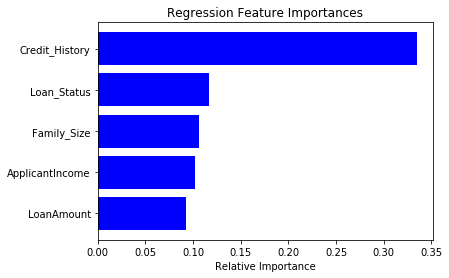

In [763]:
def k_best_features(k, features, target):
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=3000)
  
    selector = SelectKBest(f_regression, k = k)
    selector.fit(X_train, y_train)

    selected = selector.get_support()
  
    columns = []
    for i in range(len(selected)):
        if selected[i]:
            columns.append(df.columns[i])

    return columns

def random_forest_selection(k, features, target):
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(features, target, random_state=1000)

    model = RandomForestRegressor(max_depth=10, random_state=1000)
    model.fit(X_train_reg,y_train_reg)

    reg_columns = df.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)[-k:]  # top 5 features

    plt.title('Regression Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [reg_columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

num_features = 5
print(k_best_features(num_features, features, target))
random_forest_selection(num_features, features, target)

Selecting the top 5 features using each algorithm returns 4 of the same 5 features.

# Data Visualization

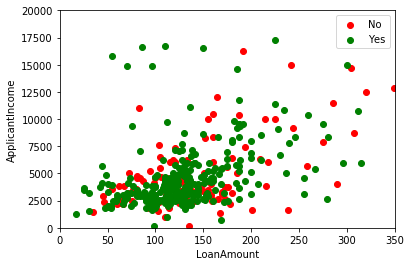

In [764]:
def plot_data(f1, xlim, f2, ylim, target):
    x_t0 = []
    x_t1 = []
    for x1, x2, y in zip(df[f1], df[f2], target):
        if y == 0:
            x_t0.append([x1, x2])
        else:
            x_t1.append([x1, x2])
    
    x_t0 = np.array(x_t0)
    x_t1 = np.array(x_t1)

    plt.scatter(x_t0[:,0], x_t0[:,1], color='red', label='No', marker='o')
    plt.scatter(x_t1[:,0], x_t1[:,1], color='green', label='Yes', marker="o")

  
    plt.legend()
    plt.xlabel(f1)
    plt.ylabel(f2)
    ax = plt.gca()
    ax.autoscale(False)

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()


plot_data("LoanAmount", [0, 350], "ApplicantIncome", [0, 20000], target)
#plot_data("Credit_History", [-.5, 1.5], "ApplicantIncome", [0, 20000], target)
#plot_data("LoanAmount", [0, 350], "Family_Size", [0, 6], target)

#
# SHOULD CONSIDER MAKING Line/Bar graphs where x axis is a feature and y axis is percent of loans accepted at that feature value. This is for the features with only values of 0,1,2,3
#


# Training the Model

In [ ]:

data_rows = []


total_score = 0
for i in range(15):
    X_train, X_test, y_train, y_test = train_test_split(features, target)
    
    #sklearnSVC = SVC(kernel = "poly", max_iter=10000).fit(X_train, y_train)
    #sklearnSVC = LinearSVC(max_iter=10000).fit(X_train, y_train)
    sklearnSVC = LogisticRegression(max_iter=10000).fit(X_train, y_train)
    #sklearnSVC = DecisionTreeClassifier().fit(X_train, y_train)

    # three types here, add NN

    #coef, intercept = sklearnSVC.coef_, sklearnSVC.intercept_
    #print(coef, intercept)
    y_pred_train = sklearnSVC.predict(X_train)
    y_pred_test = sklearnSVC.predict(X_test)
    train_error = np.sum(y_pred_train != y_train) / (1.0 * X_train.shape[0])
    test_error = np.sum(y_pred_test != y_test) / (1.0 * X_test.shape[0])
    score = sklearnSVC.score(X_test, y_test)
    total_score += score
    data_rows.append({
            "score": score,
            "train_acc": (1-train_error),
            "test_acc": (1-test_error)
        })

test_df = pd.DataFrame(data_rows)
print(total_score/15, test_df)


0.7898412698412699        score  train_acc  test_acc
0   0.752381   0.831210  0.752381
1   0.819048   0.799363  0.819048
2   0.771429   0.824841  0.771429
3   0.800000   0.818471  0.800000
4   0.771429   0.821656  0.771429
5   0.800000   0.812102  0.800000
6   0.771429   0.815287  0.771429
7   0.800000   0.808917  0.800000
8   0.809524   0.812102  0.809524
9   0.809524   0.805732  0.809524
10  0.780952   0.812102  0.780952
11  0.819048   0.796178  0.819048
12  0.819048   0.799363  0.819048
13  0.761905   0.828025  0.761905
14  0.761905   0.824841  0.761905
